# Day 4: Complete Transformer Architecture Implementation

이 노트북에서는 완전한 Transformer 아키텍처를 단계별로 구현합니다.
- Layer Normalization
- Position-wise Feed-Forward Network
- Transformer Block (Encoder & Decoder)
- Complete Transformer Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Layer Normalization 구현

Layer Normalization은 각 샘플 내에서 feature dimension을 따라 정규화합니다.

In [3]:
class LayerNorm(nn.Module):
    """Layer Normalization implementation"""
    
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch_size, seq_len, d_model]
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        # Normalize
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        # Scale and shift
        return self.gamma * x_norm + self.beta

# Test Layer Normalization
batch_size, seq_len, d_model = 2, 3, 4
x = torch.randn(batch_size, seq_len, d_model)
layer_norm = LayerNorm(d_model)
output = layer_norm(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Output mean: {output.mean(dim=-1)}")
print(f"Output std: {output.std(dim=-1)}")

Input shape: torch.Size([2, 3, 4])
Output shape: torch.Size([2, 3, 4])
Output mean: tensor([[-2.9802e-08,  5.9605e-08,  4.4703e-08],
        [-1.4901e-08,  1.4901e-08,  0.0000e+00]], grad_fn=<MeanBackward1>)
Output std: tensor([[1.1547, 1.1547, 1.1547],
        [1.1547, 1.1547, 1.1547]], grad_fn=<StdBackward0>)


In [5]:
print(torch.ones(3, 4))




tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


## 2. Position-wise Feed-Forward Network 구현

각 position에 독립적으로 적용되는 2-layer feed-forward network입니다.

In [6]:
class PositionwiseFeedForward(nn.Module):
    """Position-wise Feed-Forward Network"""
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1, activation: str = 'relu'):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
        # Activation function selection
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unknown activation: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch_size, seq_len, d_model]
        hidden = self.w_1(x)  # [batch_size, seq_len, d_ff]
        hidden = self.activation(hidden)
        hidden = self.dropout(hidden)
        output = self.w_2(hidden)  # [batch_size, seq_len, d_model]
        return output

# Test FFN
d_model, d_ff = 512, 2048
ffn = PositionwiseFeedForward(d_model, d_ff)
x = torch.randn(2, 10, d_model)
output = ffn(x)
print(f"FFN Input shape: {x.shape}")
print(f"FFN Output shape: {output.shape}")

FFN Input shape: torch.Size([2, 10, 512])
FFN Output shape: torch.Size([2, 10, 512])


## 3. Multi-Head Attention (Day 3 복습)

Day 3에서 배운 Multi-Head Attention을 다시 구현합니다.

In [13]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention mechanism"""
    
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Linear projections
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        # 1. Linear projections in batch from d_model => h x d_k
        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        # 2. Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # 3. Apply attention to values
        context = torch.matmul(attn_weights, V)
        
        # 4. Concatenate heads
        context = context.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )
        
        # 5. Final linear projection
        output = self.w_o(context)
        
        return output

# Test Multi-Head Attention
d_model, n_heads = 512, 8
mha = MultiHeadAttention(d_model, n_heads)
x = torch.randn(2, 10, d_model)
output = mha(x, x, x)
print(f"MHA Output shape: {output.shape}")

MHA Output shape: torch.Size([2, 10, 512])


## 4. Positional Encoding

Transformer는 순서 정보가 없으므로 Positional Encoding을 추가해야 합니다.

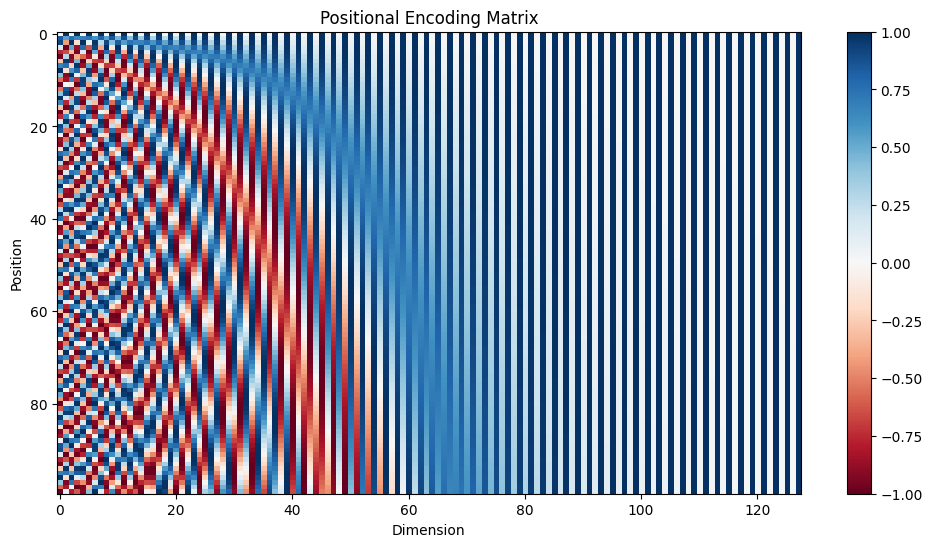

In [14]:
class PositionalEncoding(nn.Module):
    """Positional Encoding using sinusoidal functions"""
    
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Create div_term for the sinusoidal pattern
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * 
            -(math.log(10000.0) / d_model)
        )
        
        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # Apply cos to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension and register as buffer
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch_size, seq_len, d_model]
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

# Visualize Positional Encoding
d_model = 128
max_len = 100
pos_encoding = PositionalEncoding(d_model, max_len)

# Get the positional encoding matrix
pe_matrix = pos_encoding.pe[0, :max_len, :].numpy()

plt.figure(figsize=(12, 6))
plt.imshow(pe_matrix, cmap='RdBu', aspect='auto')
plt.colorbar()
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding Matrix')
plt.show()

## 5. Transformer Encoder Block

이제 모든 구성 요소를 결합하여 Encoder Block을 만듭니다.

In [15]:
class EncoderBlock(nn.Module):
    """Transformer Encoder Block"""
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # Multi-Head Attention
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # Feed-Forward Network
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Self-Attention with residual connection and layer norm
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # FFN with residual connection and layer norm
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        
        return x

# Test Encoder Block
encoder_block = EncoderBlock(d_model=512, n_heads=8, d_ff=2048)
x = torch.randn(2, 10, 512)
output = encoder_block(x)
print(f"Encoder Block Output shape: {output.shape}")

Encoder Block Output shape: torch.Size([2, 10, 512])


## 6. Transformer Decoder Block

Decoder Block은 Encoder Block에 Cross-Attention이 추가됩니다.

In [16]:
class DecoderBlock(nn.Module):
    """Transformer Decoder Block"""
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # Masked Self-Attention
        self.masked_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # Cross-Attention
        self.cross_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        # Feed-Forward Network
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm3 = LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        
        # Masked Self-Attention
        masked_attn_output = self.masked_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(masked_attn_output))
        
        # Cross-Attention with encoder output
        cross_attn_output = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout2(cross_attn_output))
        
        # Feed-Forward Network
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout3(ffn_output))
        
        return x

# Test Decoder Block
decoder_block = DecoderBlock(d_model=512, n_heads=8, d_ff=2048)
decoder_input = torch.randn(2, 10, 512)
encoder_output = torch.randn(2, 15, 512)
output = decoder_block(decoder_input, encoder_output)
print(f"Decoder Block Output shape: {output.shape}")

Decoder Block Output shape: torch.Size([2, 10, 512])


## 7. Complete Transformer Model

모든 구성 요소를 결합하여 완전한 Transformer 모델을 만듭니다.

In [29]:
class Transformer(nn.Module):
    """Complete Transformer Model"""
    
    def __init__(self, 
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 d_model: int = 512,
                 n_heads: int = 8,
                 n_encoder_layers: int = 6,
                 n_decoder_layers: int = 6,
                 d_ff: int = 2048,
                 max_len: int = 5000,
                 dropout: float = 0.1):
        super().__init__()
        
        # Embeddings and Positional Encoding
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_encoder_layers = n_encoder_layers
        self.n_decoder_layers = n_decoder_layers
        self.d_ff = d_ff
        self.max_len = max_len
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size

        # Encoder
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_encoder_layers)
        ])
        
        # Decoder
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_decoder_layers)
        ])
        
        # Output projection
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def generate_mask(self, sz: int) -> torch.Tensor:
        """Generate causal mask for decoder"""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask
    
    def forward(self, 
                src: torch.Tensor,
                tgt: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        
        # Source embedding
        src_emb = self.src_embedding(src) * math.sqrt(self.d_model)
        src_emb = self.positional_encoding(src_emb)
        src_emb = self.dropout(src_emb)
        
        # Target embedding
        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.positional_encoding(tgt_emb)
        tgt_emb = self.dropout(tgt_emb)
        
        # Encoder
        encoder_output = src_emb
        for encoder_layer in self.encoder_layers:
            encoder_output = encoder_layer(encoder_output, src_mask)
        
        # Decoder
        decoder_output = tgt_emb
        for decoder_layer in self.decoder_layers:
            decoder_output = decoder_layer(decoder_output, encoder_output, src_mask, tgt_mask)
        
        # Output projection
        output = self.output_projection(decoder_output)
        
        return output

# Create model instance
model = Transformer(
    src_vocab_size=10000,
    tgt_vocab_size=10000,
    d_model=512,
    n_heads=8,
    n_encoder_layers=6,
    n_decoder_layers=6,
    d_ff=2048
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 59,508,496
Trainable parameters: 59,508,496


## 8. Training Example

간단한 학습 예제를 구현합니다.

In [30]:
def train_step(model: nn.Module, 
               src: torch.Tensor,
               tgt: torch.Tensor,
               optimizer: torch.optim.Optimizer,
               criterion: nn.Module) -> float:
    """Single training step"""
    
    model.train()
    optimizer.zero_grad()
    
    # Prepare target input and output
    tgt_input = tgt[:, :-1]  # All tokens except last
    tgt_output = tgt[:, 1:]  # All tokens except first
    
    # Generate target mask
    tgt_mask = model.generate_mask(tgt_input.size(1)).to(tgt_input.device)
    
    # Forward pass
    output = model(src, tgt_input, tgt_mask=tgt_mask)
    
    # Calculate loss
    output = output.reshape(-1, output.size(-1))
    tgt_output = tgt_output.reshape(-1)
    loss = criterion(output, tgt_output)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()

# Create dummy data for demonstration
batch_size = 8
src_seq_len = 20
tgt_seq_len = 20
src_vocab_size = 10000
tgt_vocab_size = 10000

# Random source and target sequences
src = torch.randint(0, src_vocab_size, (batch_size, src_seq_len))
tgt = torch.randint(0, tgt_vocab_size, (batch_size, tgt_seq_len))

# Setup training
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=256,  # Smaller for demo
    n_heads=4,
    n_encoder_layers=2,
    n_decoder_layers=2,
    d_ff=1024
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding

# Training loop (simplified)
n_epochs = 5
for epoch in range(n_epochs):
    loss = train_step(model, src.to(device), tgt.to(device), optimizer, criterion)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}")

Epoch 1/5, Loss: 9.2239
Epoch 2/5, Loss: 9.1354
Epoch 3/5, Loss: 9.0732
Epoch 4/5, Loss: 8.9944
Epoch 5/5, Loss: 8.9636


## 9. Inference Example

추론 시 auto-regressive 생성을 구현합니다.

In [31]:
@torch.no_grad()
def generate(model: nn.Module,
             src: torch.Tensor,
             max_len: int = 50,
             start_token: int = 1,
             end_token: int = 2) -> torch.Tensor:
    """Generate output sequence using greedy decoding"""
    
    model.eval()
    device = next(model.parameters()).device
    
    # Encode source
    src_emb = model.src_embedding(src) * math.sqrt(model.src_embedding.embedding_dim)
    src_emb = model.positional_encoding(src_emb)
    
    encoder_output = src_emb
    for encoder_layer in model.encoder_layers:
        encoder_output = encoder_layer(encoder_output)
    
    # Start with start token
    tgt = torch.tensor([[start_token]], device=device)
    
    for _ in range(max_len):
        # Decode
        tgt_emb = model.tgt_embedding(tgt) * math.sqrt(model.tgt_embedding.embedding_dim)
        tgt_emb = model.positional_encoding(tgt_emb)
        
        # Generate target mask
        tgt_mask = model.generate_mask(tgt.size(1)).to(device)
        
        decoder_output = tgt_emb
        for decoder_layer in model.decoder_layers:
            decoder_output = decoder_layer(decoder_output, encoder_output, tgt_mask=tgt_mask)
        
        # Get next token
        output = model.output_projection(decoder_output)
        next_token = output[:, -1, :].argmax(dim=-1, keepdim=True)
        
        # Append to target sequence
        tgt = torch.cat([tgt, next_token], dim=1)
        
        # Stop if end token is generated
        if next_token.item() == end_token:
            break
    
    return tgt

# Test generation
src_sequence = torch.randint(0, src_vocab_size, (1, 10)).to(device)
generated = generate(model, src_sequence)
print(f"Generated sequence shape: {generated.shape}")
print(f"Generated tokens: {generated[0].tolist()[:20]}...")  # Show first 20 tokens

Generated sequence shape: torch.Size([1, 51])
Generated tokens: [1, 246, 246, 6096, 5793, 5793, 5793, 7222, 4953, 4953, 4953, 4953, 1062, 1062, 1062, 1062, 1062, 1062, 1062, 1062]...


## 10. Attention Visualization

Attention weights를 시각화하여 모델이 어떻게 작동하는지 확인합니다.

In [35]:
def visualize_attention(model: nn.Module, src: torch.Tensor, tgt: torch.Tensor):
    """Visualize attention weights"""
    
    model.eval()
    
    # Hook을 사용하여 attention weights 추출
    attention_weights = []
    
    def hook_fn(module, input, output):
        attention_weights.append(output)
    
    # Register hooks on attention layers
    hooks = []
    for layer in model.decoder_layers:
        hook = layer.cross_attention.register_forward_hook(hook_fn)
        hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        _ = model(src, tgt)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Visualize attention from first decoder layer
    if attention_weights:
        attn = attention_weights[0].cpu().numpy()
        
        plt.figure(figsize=(10, 8))
        plt.imshow(attn[0, 0], cmap='Blues', aspect='auto')
        plt.colorbar()
        plt.xlabel('Source Position')
        plt.ylabel('Target Position')
        plt.title('Cross-Attention Weights (Layer 1, Head 1)')
        plt.show()

# Note: This visualization would require actual attention weights
# which are not directly returned in our current implementation
print("Attention visualization would require modifying the attention module to return weights.")

Attention visualization would require modifying the attention module to return weights.


## 11. Model Analysis

모델의 다양한 측면을 분석합니다.

In [33]:
def analyze_model(model: nn.Module):
    """Analyze model architecture and parameters"""
    
    # Parameter count by component
    component_params = {
        'Embeddings': 0,
        'Encoder': 0,
        'Decoder': 0,
        'Output': 0
    }
    
    # Count embedding parameters
    component_params['Embeddings'] = (
        sum(p.numel() for p in model.src_embedding.parameters()) +
        sum(p.numel() for p in model.tgt_embedding.parameters())
    )
    
    # Count encoder parameters
    for layer in model.encoder_layers:
        component_params['Encoder'] += sum(p.numel() for p in layer.parameters())
    
    # Count decoder parameters
    for layer in model.decoder_layers:
        component_params['Decoder'] += sum(p.numel() for p in layer.parameters())
    
    # Count output projection parameters
    component_params['Output'] = sum(p.numel() for p in model.output_projection.parameters())
    
    # Display results
    total_params = sum(component_params.values())
    
    print("\n=== Model Parameter Analysis ===")
    print(f"Total Parameters: {total_params:,}\n")
    
    for component, count in component_params.items():
        percentage = (count / total_params) * 100
        print(f"{component:12s}: {count:10,} ({percentage:5.1f}%)")
    
    # Memory estimation
    param_size_mb = (total_params * 4) / (1024 * 1024)  # 4 bytes per float32
    print(f"\nEstimated Model Size: {param_size_mb:.1f} MB (float32)")
    
    # Computational complexity
    print("\n=== Computational Complexity ===")
    batch_size = 32
    seq_len = 100
    d_model = 512
    n_heads = 8
    
    # Attention complexity: O(n²·d)
    attention_flops = batch_size * seq_len * seq_len * d_model
    print(f"Attention FLOPs per layer: {attention_flops:,}")
    
    # FFN complexity: O(n·d·4d)
    ffn_flops = batch_size * seq_len * d_model * 4 * d_model
    print(f"FFN FLOPs per layer: {ffn_flops:,}")

# Analyze the model
analyze_model(model)


=== Model Parameter Analysis ===
Total Parameters: 11,376,400

Embeddings  :  5,120,000 ( 45.0%)
Encoder     :  1,579,520 ( 13.9%)
Decoder     :  2,106,880 ( 18.5%)
Output      :  2,570,000 ( 22.6%)

Estimated Model Size: 43.4 MB (float32)

=== Computational Complexity ===
Attention FLOPs per layer: 163,840,000
FFN FLOPs per layer: 3,355,443,200


In [36]:
import torch.nn as nn

# 간단한 모델
model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 5)
)

# 각 레이어의 파라미터 수 확인
for name, param in model.named_parameters():
    print(f"{name}: {param.shape} → {param.numel()}개")
    # weight: torch.Size([20, 10]) → 200개
    # bias: torch.Size([20]) → 20개
    # weight: torch.Size([5, 20]) → 100개
    # bias: torch.Size([5]) → 5개

0.weight: torch.Size([20, 10]) → 200개
0.bias: torch.Size([20]) → 20개
2.weight: torch.Size([5, 20]) → 100개
2.bias: torch.Size([5]) → 5개


## 12. 실습 과제

다음 과제들을 수행해보세요:

1. **Pre-Norm vs Post-Norm**: Layer Normalization 위치를 바꿔보고 성능 비교
2. **Activation Functions**: ReLU, GELU, SwiGLU 등 다양한 활성화 함수 비교
3. **Hidden Dimension**: FFN의 hidden dimension 비율 실험 (2x, 4x, 8x)
4. **Depth vs Width**: Layer 수와 dimension 크기의 trade-off 분석
5. **Attention Patterns**: 다양한 attention mask 패턴 실험

In [34]:
# 실습 과제 예제: Pre-Norm Transformer Block
class PreNormEncoderBlock(nn.Module):
    """Pre-Norm version of Transformer Encoder Block"""
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Pre-Norm for attention
        x_norm = self.norm1(x)
        attn_output = self.attention(x_norm, x_norm, x_norm, mask)
        x = x + self.dropout1(attn_output)
        
        # Pre-Norm for FFN
        x_norm = self.norm2(x)
        ffn_output = self.ffn(x_norm)
        x = x + self.dropout2(ffn_output)
        
        return x

print("Pre-Norm Encoder Block 구현 완료!")
print("이제 Post-Norm과 Pre-Norm의 성능을 비교해보세요.")

Pre-Norm Encoder Block 구현 완료!
이제 Post-Norm과 Pre-Norm의 성능을 비교해보세요.


## Summary

이 노트북에서 우리는:
1. Layer Normalization과 Residual Connection의 중요성을 이해했습니다
2. Position-wise Feed-Forward Network를 구현했습니다
3. 완전한 Transformer Encoder/Decoder Block을 만들었습니다
4. 전체 Transformer 모델을 조립했습니다
5. Training과 Inference 과정을 구현했습니다

다음 단계 (Day 5)에서는 GPT 스타일의 Decoder-only 모델과 텍스트 생성을 다룰 예정입니다.